In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ETFunctions as et
%matplotlib inline

# The Winchmore Met Data

The Winchmore Met site is a high standard meteorological site approximately 30 km from the trial site at Wakanui.  This data is used as a reference to check the met data recorded locally at the trial in Wakanui

## Bring in the Winchmore met data

In [2]:
WinchmoreRawData = pd.read_csv('Winchmore.met',skiprows=11,usecols=[1,4,5,7,8,10,19],
                      names=['DATE','WIND','RAIN','TMAX','TMIN','VPRS','SRAD'],
                     na_values = ['-'])
WinchmoreRawData.loc[:,'DATE'] =  pd.to_datetime(WinchmoreRawData.loc[:,'DATE'])
WinchmoreRawData.loc[:,'WIND'] = WinchmoreRawData.loc[:,'WIND'] * 1000 / (24 * 60 * 60)
idxSer = range(WinchmoreRawData.index.size)
WinchmoreRawData.loc[:,'Year'] = [WinchmoreRawData.loc[x,'DATE'].year for x in idxSer]
WinchmoreRawData.loc[:,'Day'] = [WinchmoreRawData.loc[x,'DATE'].dayofyear for x in idxSer]
WinchmoreRawData.set_index(['Year','Day'],inplace=True,drop=False)
WinchmoreRawData.iloc[:,1:].where(WinchmoreRawData.iloc[:,1:]>-90,np.nan,inplace=True)

## Make graphs of long term means

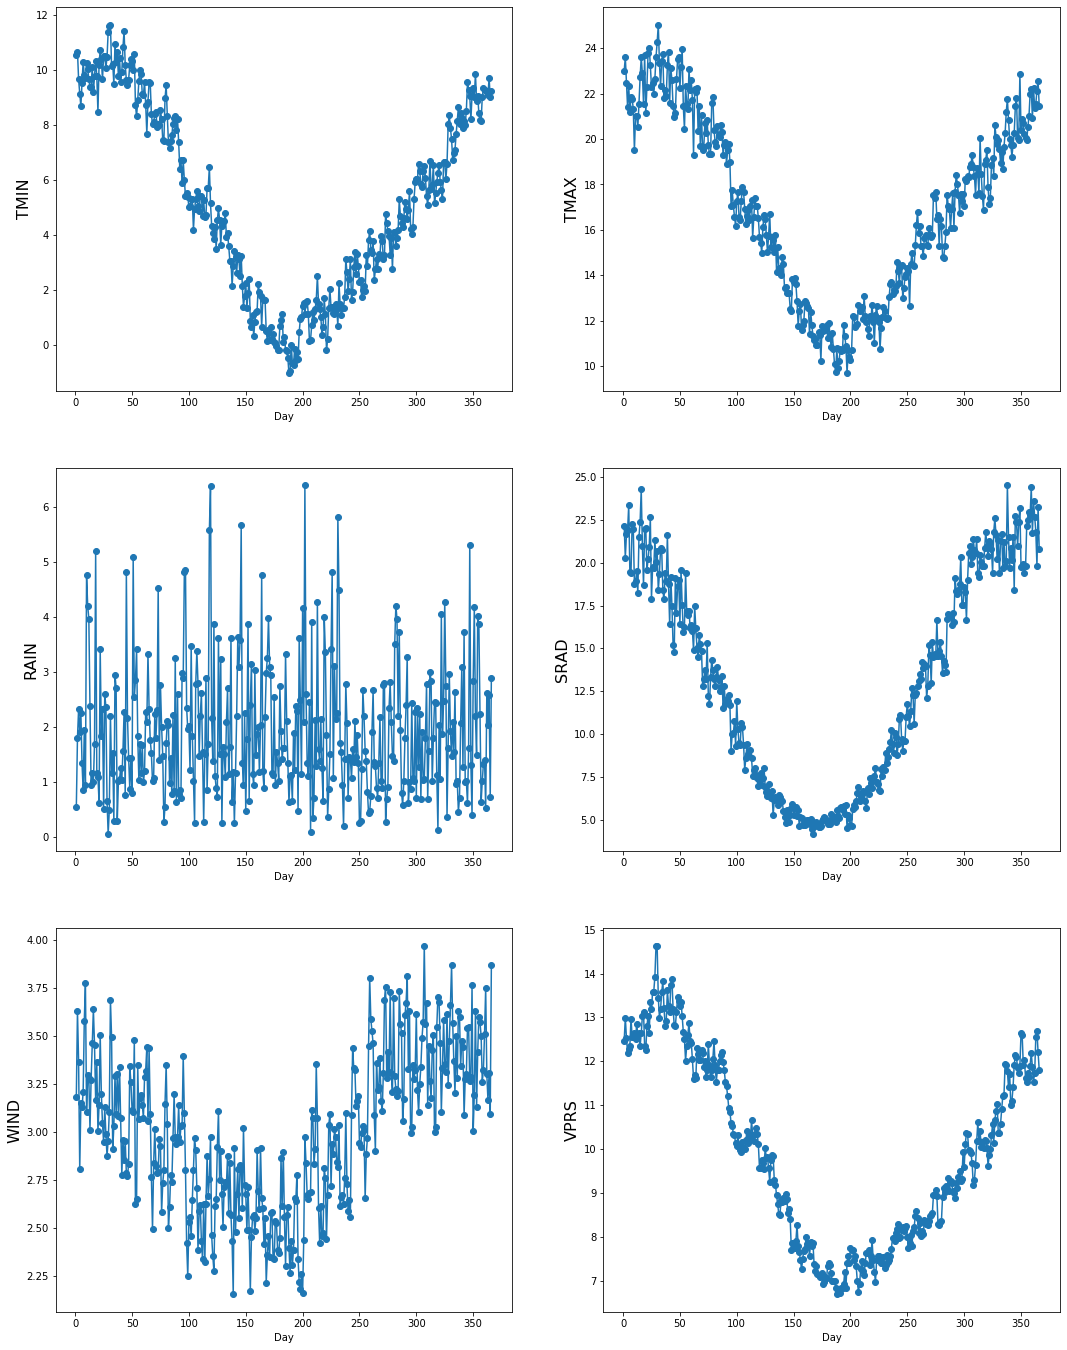

In [3]:
Fig = plt.figure(figsize = (18,24))
Position = 1
for x in [u'TMIN', u'TMAX', u'RAIN', u'SRAD', u'WIND', u'VPRS']:
    Fig.add_subplot(3,2,Position)
    Means = WinchmoreRawData.groupby(level='Day').mean()
    Means.loc[:,x].plot(marker='o')
    plt.ylabel(x,fontsize = 16)
    Position +=1
Fig.patch.set_facecolor('white')

## Some pretty summary graphs

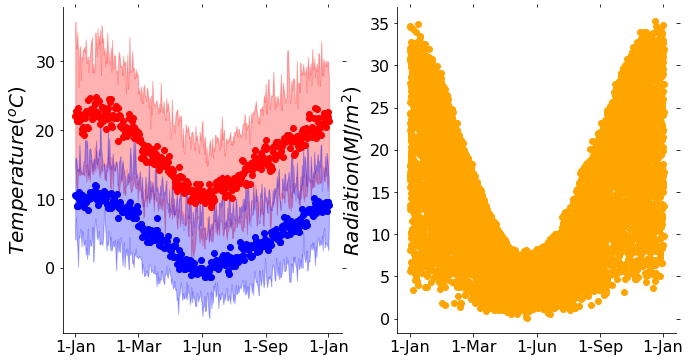

In [4]:
Fig = plt.figure(figsize = (11,6))
#for x in [u'TMIN', u'TMAX', u'RAIN', u'SRAD', u'WIND', u'VPRS']:
Ax = Fig.add_subplot(1,2,1)
plt.tick_params(labelsize=16)
Ax.spines['right'].set_visible(False)
Ax.spines['top'].set_visible(False)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on')
plt.tick_params(axis='y', which='both', left='on',right='off', labelbottom='on')
Medians = WinchmoreRawData.loc[:,'TMAX'].groupby(level='Day').median()
#SEs = LincolnRawData.groupby(level='Day').std()
Upper = WinchmoreRawData.loc[:,'TMAX'].groupby(level='Day').max()
Lower = WinchmoreRawData.loc[:,'TMAX'].groupby(level='Day').min()
plt.fill_between(Medians.index,
                     Upper,
                     Lower,
                alpha = 0.3,color='r')
plt.plot(Medians,'o',color='r')
Medians = WinchmoreRawData.loc[:,'TMIN'].groupby(level='Day').median()
#SEs = LincolnRawData.groupby(level='Day').std()
Upper = WinchmoreRawData.loc[:,'TMIN'].groupby(level='Day').max()
Lower = WinchmoreRawData.loc[:,'TMIN'].groupby(level='Day').min()
plt.fill_between(Medians.index,
                     Upper,
                     Lower,
                alpha = 0.3,color='b')
plt.plot(Medians,'o',color='b')
plt.ylabel(r'$Temperature (^oC)$',fontsize=20)
Ax.set_xticks([1,92,183,275,365])
Ax.set_xticklabels(['1-Jan','1-Mar','1-Jun','1-Sep','1-Jan'])
Ax = Fig.add_subplot(1,2,2)
plt.tick_params(labelsize=16)
Ax.spines['right'].set_visible(False)
Ax.spines['top'].set_visible(False)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on')
plt.tick_params(axis='y', which='both', left='on',right='off', labelbottom='on')
DayIndexed = WinchmoreRawData.copy()
DayIndexed.index = DayIndexed.index.droplevel('Year')
plt.plot(DayIndexed.index,DayIndexed.loc[:,'SRAD'],'o',color='orange')
plt.ylabel(r'$Radiation (MJ/m^2)$',fontsize=20)
Ax.set_xticks([1,92,183,275,365])
Ax.set_xticklabels(['1-Jan','1-Mar','1-Jun','1-Sep','1-Jan'])
Fig.patch.set_facecolor('white')

# Clean up the Winchmore data where necessary

## Replace suspect data with nan

In [5]:
Winchmore = WinchmoreRawData.copy()
Winchmore.loc[:,'TMIN'].where(Winchmore.loc[:,'TMIN']>-10,np.nan,inplace=True)
Winchmore.loc[:,'TMAX'].where(Winchmore.loc[:,'TMAX']<35,np.nan,inplace=True)
Winchmore.loc[:,'RAIN'].where(Winchmore.loc[:,'RAIN']<200,np.nan,inplace=True)
Winchmore.loc[:,'SRAD'].where(Winchmore.loc[:,'SRAD']<35,np.nan,inplace=True)
Winchmore.loc[:,'WIND'].where(Winchmore.loc[:,'WIND']<2000,np.nan,inplace=True)
Winchmore.loc[:,'VPRS'].where(Winchmore.loc[:,'VPRS']<30,np.nan,inplace=True)

## The replace the nan's with long term mean

In [6]:
for var in [u'TMIN', u'TMAX', u'RAIN', u'SRAD', u'WIND', u'VPRS']:
    for x in Winchmore.index:
        Day = Winchmore.loc[x,'Day']
        if np.isnan(Winchmore.loc[x,var]):
            Winchmore.loc[x,var] = Means.loc[Day,var]

## Put in a Date column into Winchmore Data

In [7]:
for x in Winchmore.index:
    OneDate = datetime.datetime(Winchmore.loc[x,'Year'],1,1)
    JDayLessOne = int(Winchmore.loc[x,'Day']-1)
    TodayDate = OneDate + datetime.timedelta(JDayLessOne)
    Winchmore.loc[x,'Date'] = TodayDate

## Put Winchmore onto a complete date index so any missing days are apparent

In [8]:
StartDate = Winchmore.DATE.min()
EndDate = Winchmore.DATE.max()
AllDates = pd.date_range(StartDate,EndDate)
Winchmore.set_index('DATE',drop=False,inplace=True)
Winchmore = Winchmore.loc[AllDates,:]

## Fill year and day columns for missing dates

In [9]:
for x in Winchmore.index:
    if np.isnan(Winchmore.loc[x,'Year']):
        Winchmore.loc[x,'Year'] = Winchmore.loc[x,:].name.year
        Winchmore.loc[x,'Day'] = Winchmore.loc[x,:].name.dayofyear
        Winchmore.loc[x,'Date'] = Winchmore.loc[x,:].name

## Graph cleaned data to make sure all is OK

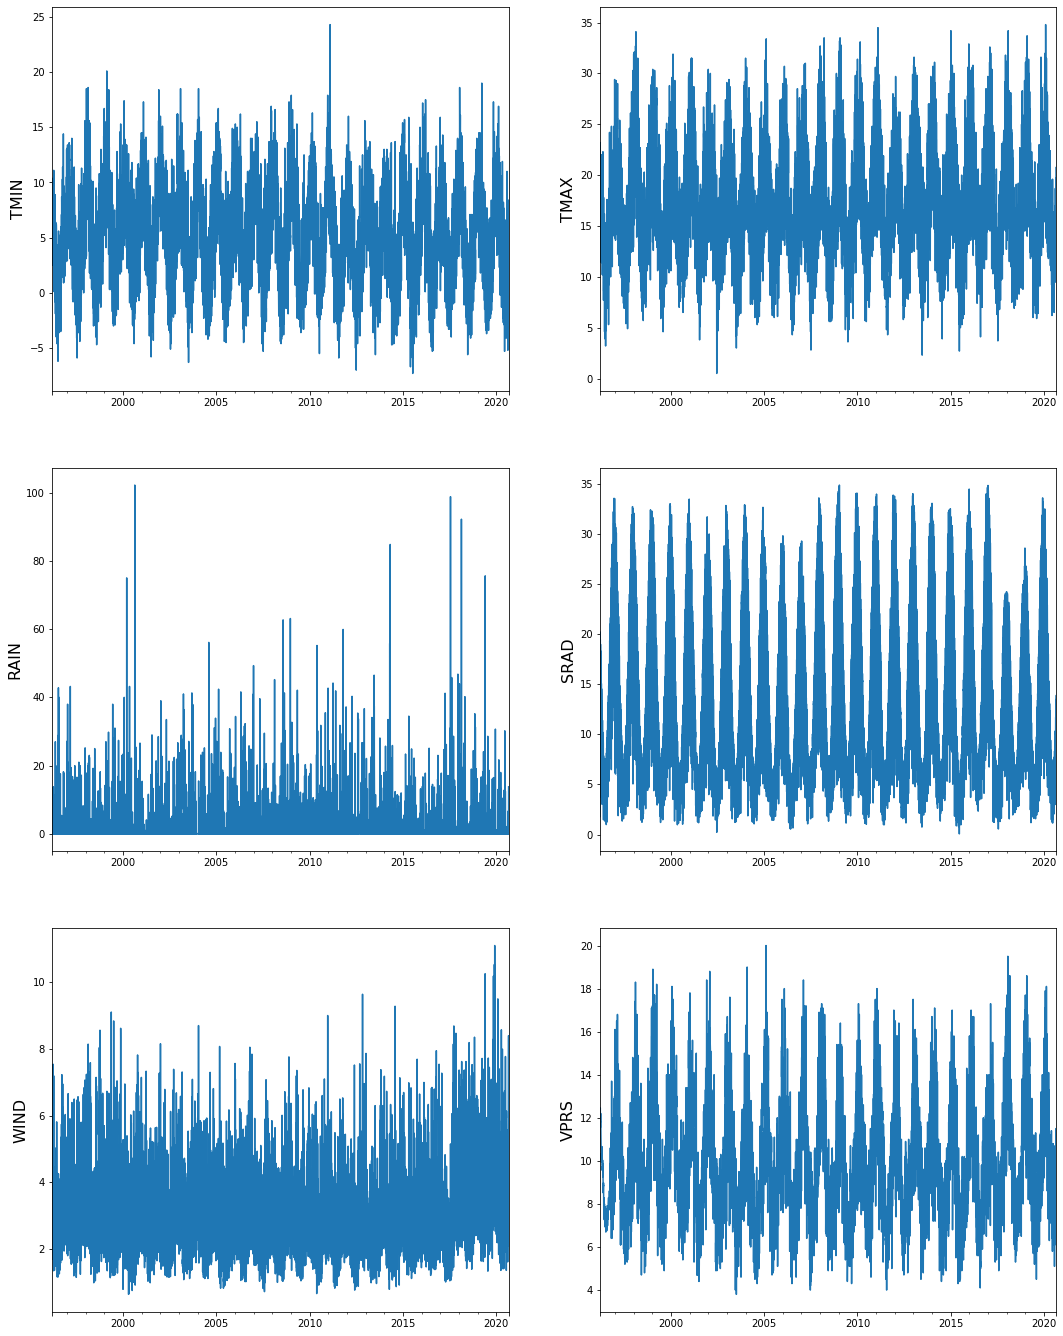

In [10]:
Fig = plt.figure(figsize = (18,24))
Position = 1
for x in [u'TMIN', u'TMAX', u'RAIN', u'SRAD', u'WIND', u'VPRS']:
    Fig.add_subplot(3,2,Position)
    Winchmore.loc[:,x].plot()
    plt.ylabel(x,fontsize = 16)
    Position +=1
Fig.patch.set_facecolor('white')

## There is a problem with the radiation at Winchmore in 2017-2019.  Multiply to correct

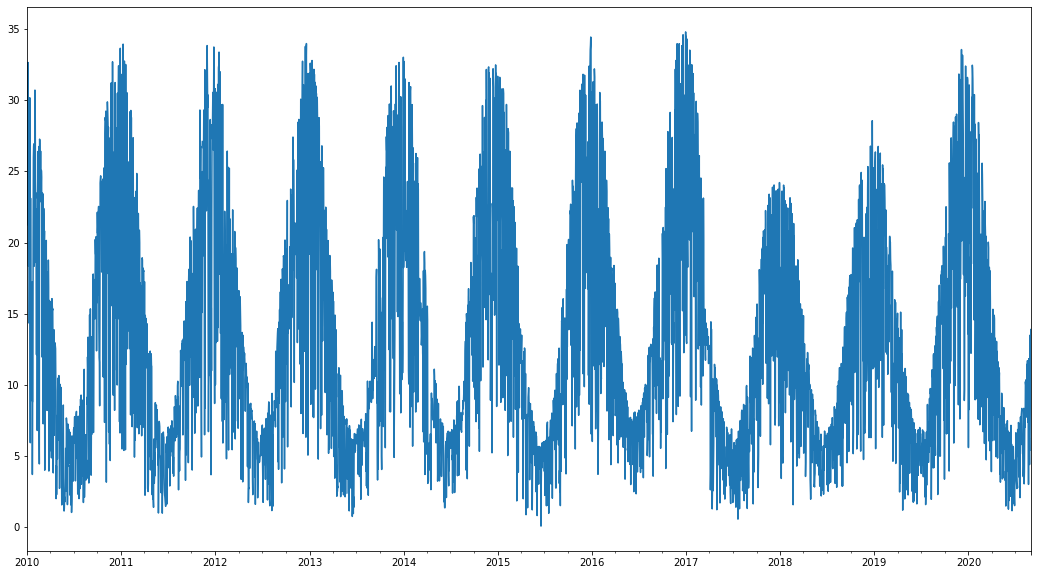

In [11]:
Winchmore.loc['2010-01-01':,u'SRAD'].plot(figsize=(18,10))

In [12]:
Winchmore.loc['2017-03-10':'2018-06-01',u'SRAD'] = Winchmore.loc['2017-03-10':'2018-06-01',u'SRAD'] * 1.3
Winchmore.loc['2018-06-01':'2019-04-01',u'SRAD'] = Winchmore.loc['2018-06-01':'2019-04-01',u'SRAD'] * 1.3

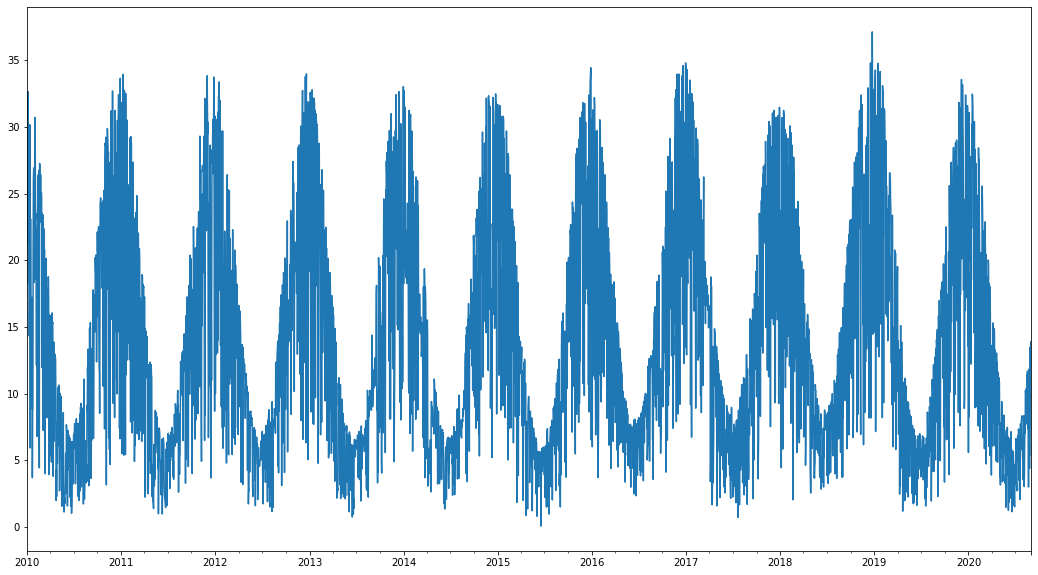

In [13]:
Winchmore.loc['2010-01-01':,u'SRAD'].plot(figsize=(18,10))

## Set the date as index to enable matching with Wakanui data

In [14]:
Winchmore.set_index('Date',inplace=True)

# The Wakanui data. 
Temperature, solar radiation and rainfall measured at the site for each year of trial

## Bring in the 2016/17 data

In [15]:
Wakanui1617 = pd.read_excel('c:\\GitHubRepos\\2020\\Weather\\Wakanui1617.xlsx',
              skiprows=4,header = None,na_values='NAN')
Wakanui1617.columns = ['DATE','Rec','Temp','RH','Radn(kW)','RadnMJ','RAIN']
Wakanui1617.set_index('DATE',inplace=True)
Wakanui1617daily = pd.DataFrame(index=Wakanui1617.Temp.resample('d').min().index)
Wakanui1617daily.loc[:,'TMIN'] = Wakanui1617.Temp.resample('d').min()
Wakanui1617daily.loc[:,'TMAX'] = Wakanui1617.Temp.resample('d').max()
Wakanui1617daily.loc[:,'TMEAN'] = (Wakanui1617daily.loc[:,'TMIN'] + Wakanui1617daily.loc[:,'TMAX'])/2
Wakanui1617daily.loc[:,'RAIN'] = Wakanui1617.RAIN.resample('d').sum()
Wakanui1617daily.loc[:,'SRAD'] = pd.to_numeric(Wakanui1617.loc[:,'RadnMJ'],errors='coerce').resample('d').sum()
Wakanui1617daily.loc[:,'RH'] = Wakanui1617.RH.resample('d').mean()/100
Wakanui1617daily.loc[:,'VPRS'] = [et.saturated_vapor_pressure(Wakanui1617daily.loc[x,'TMEAN']) * \
                                 Wakanui1617daily.loc[x,'RH'] for x in Wakanui1617daily.index]

## Regress against Winchmore data to check

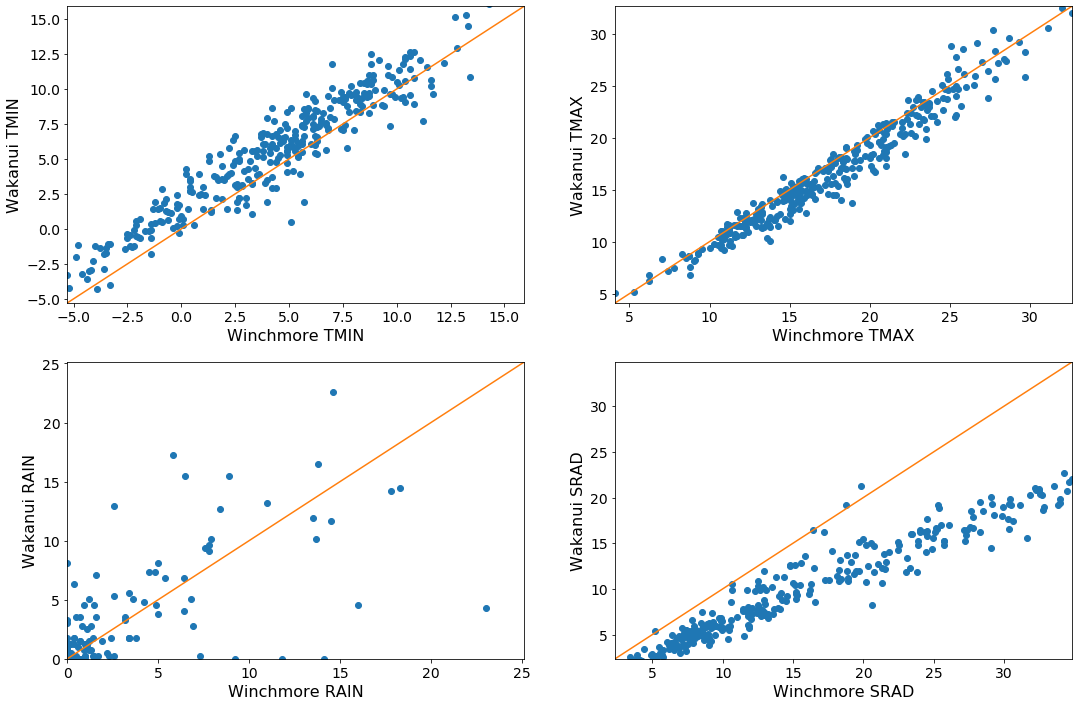

In [16]:
Fig = plt.figure(figsize = (18,12))
Position = 1
for x in [u'TMIN', u'TMAX', u'RAIN', u'SRAD']:
    Fig.add_subplot(2,2,Position)
    Ind = Wakanui1617daily.loc[:,x].index
    plt.plot(Winchmore.loc[Ind,x],Wakanui1617daily.loc[:,x],'o')
    maxx = Winchmore.loc[Ind,x].max()
    minx = Winchmore.loc[Ind,x].min()
    plt.ylim(minx,maxx)
    plt.xlim(minx,maxx)
    plt.ylabel('Wakanui '+x,fontsize=16)
    plt.xlabel('Winchmore '+x,fontsize=16)
    plt.tick_params(labelsize=14)
    plt.plot([minx,maxx],[minx,maxx],'-')
    Position +=1
Fig.patch.set_facecolor('white')

### OK agreement between Wakanui and Winchmore but Min Temp from Winchmore needs to have 1oC added to approximate Wakanui the radiatin data from Wakanui is off so needs to be multiplied by 1.6 to adjust for what appears to be an incorrect calibration coefficient


## Bring in 17/18 data

In [17]:
Wakanui1718 = pd.read_excel('c:\\GitHubRepos\\2020\\Weather\\Wakanui1718.xlsx',
              skiprows=4,header = None,na_values='NAN')
Wakanui1718.columns = ['DATE','Rec','Temp','RH','Radn(kW)','RadnMJ','RAIN']
Wakanui1718.set_index('DATE',inplace=True)
Wakanui1718daily = pd.DataFrame(index=Wakanui1718.Temp.resample('d').min().index)
Wakanui1718daily.loc[:,'TMIN'] = Wakanui1718.Temp.resample('d').min() 
Wakanui1718daily.loc[:,'TMAX'] = Wakanui1718.Temp.resample('d').max()
Wakanui1718daily.loc[:,'TMEAN'] = (Wakanui1718daily.loc[:,'TMIN'] + Wakanui1718daily.loc[:,'TMAX'])/2
Wakanui1718daily.loc[:,'RAIN'] = Wakanui1718.RAIN.resample('d').sum()
Wakanui1718daily.loc[:,'SRAD'] = pd.to_numeric(Wakanui1718.loc[:,'RadnMJ'],errors='coerce').resample('d').sum()
Wakanui1718daily.loc[:,'RH'] = Wakanui1718.RH.resample('d').mean()/100
Wakanui1718daily.loc[:,'VPRS'] = [et.saturated_vapor_pressure(Wakanui1718daily.loc[x,'TMEAN']) * \
                                 Wakanui1718daily.loc[x,'RH'] for x in Wakanui1718daily.index]

## Join with other Wakanui data and remove any errant values

In [18]:
WakanuiLocal = pd.concat([Wakanui1617daily,Wakanui1718daily])
WakanuiLocal.loc[:,'TMIN'].where(WakanuiLocal.loc[:,'TMIN']>-10,np.nan,inplace=True)
WakanuiLocal.loc[:,'TMAX'].where(WakanuiLocal.loc[:,'TMAX']<35,np.nan,inplace=True)
WakanuiLocal.loc[:,'RAIN'].where(WakanuiLocal.loc[:,'RAIN']<200,np.nan,inplace=True)
WakanuiLocal.loc[:,'SRAD'].where(WakanuiLocal.loc[:,'SRAD']<35,np.nan,inplace=True)
WakanuiLocal.loc[:,'SRAD'].where(WakanuiLocal.loc[:,'SRAD']>0,np.nan,inplace=True)
WakanuiLocal.drop_duplicates(inplace=True)
WakanuiLocal.drop(['RH','TMEAN'],axis=1,inplace=True)
#Apply corrections based on comparision with Winchmore above
WakanuiLocal.loc[:,'TMIN'] = WakanuiLocal.loc[:,'TMIN'] -1
WakanuiLocal.loc[:,'SRAD'] = WakanuiLocal.loc[:,'SRAD'] * 1.6

## Make an empty DataFrame with all the met data needed for APMIP over the dates required and include the Wakanui weather measured on site

In [19]:
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2020,9,1)
DateIndex = pd.to_datetime([start + datetime.timedelta(days=x) for x in range(0, (end-start).days)])
Wakanui = pd.DataFrame(index = DateIndex,
                       columns = [u'TMIN', u'TMAX', u'RAIN', u'SRAD', u'WIND', u'VPRS'],  
                       data = np.nan)
Wakanui.index.name = 'Date'
Wakanui.update(WakanuiLocal)

## This DataFrame contains a number of gaps so plug the gaps with Winchmore met data

In [20]:
for var in [u'TMIN', u'TMAX', u'RAIN', u'SRAD', u'WIND', u'VPRS']:
    for x in Wakanui.index:
        if np.isnan(Wakanui.loc[x,var]):
            Wakanui.loc[x,var] = Winchmore.loc[x,var]

## The figure below displays the met data included in the Wakanui met file with the green data being measured on site and the blue data being measured at the nearby Lincoln site

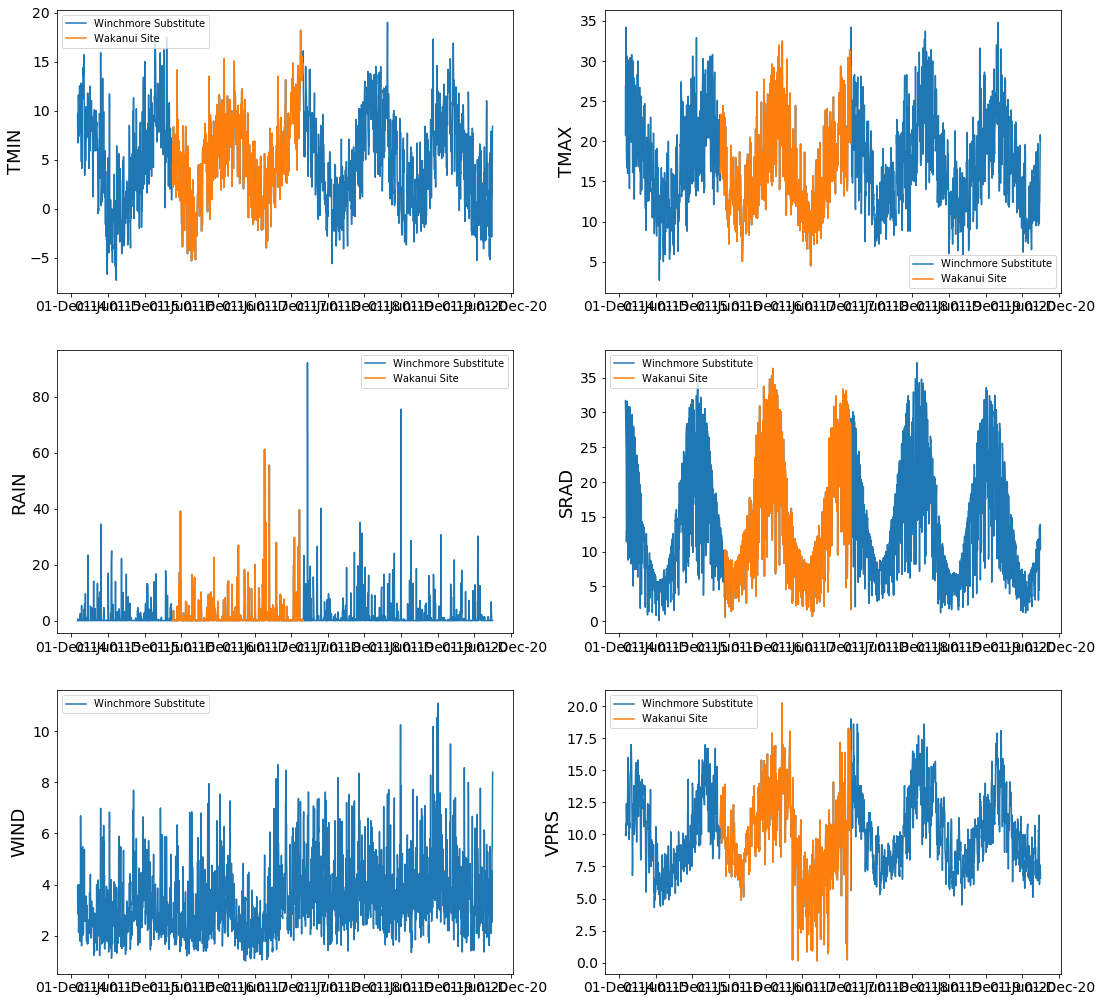

In [21]:
Fig = plt.figure(figsize = (18,24))
Position = 1
for x in [u'TMIN', u'TMAX', u'RAIN', u'SRAD', u'WIND', u'VPRS']:
    axis = Fig.add_subplot(4,2,Position)
    plt.plot(Wakanui.loc[:,x],label = 'Winchmore Substitute')
    try:
        plt.plot(WakanuiLocal.loc[:,x],label = 'Wakanui Site')
    except:
        dummy = 'dumbass'
    plt.legend()
    plt.ylabel(x,fontsize=18)
    plt.tick_params(labelsize=14)
    axis.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
    Position +=1
Fig.patch.set_facecolor('white')

In [22]:
NameMap = {'year':'year',
           'day':'day',
           'TMIN':'mint',
           'TMAX':'maxt',
           'RAIN':'rain',
           'SRAD':'radn',
           'WIND':'wind',
           'VPRS':'vp'}

UnitMap = {'year':'()',
           'day':'()',
           'mint':'oC',
           'maxt':'oC',
           'rain':'mm',
           'radn':'MJ/m2/d',
           'wind':'m/s',
           'vp':'mbar'}

Wakanui.loc[:,'WIND'] = (Wakanui.loc[:,'WIND'])
Wakanui.loc[:,'year'] = [x.year for x in Wakanui.index]
Wakanui.loc[:,'day'] = [x.dayofyear for x in Wakanui.index]
Wakanui.columns = [NameMap[x] for x in Wakanui.columns]
Wakanui.reset_index(inplace=True)
Wakanui.drop('Date',axis=1,inplace=True)
Wakanui = Wakanui.loc[:,list(UnitMap)]
Wakanui = Wakanui.round(1)
TopLine = pd.DataFrame(columns = Wakanui.columns)
TopLine.loc[0,'year'] = '[weather.met.weather]'
TopLine.loc[1,'year'] = 'Site=Wakanui'
TopLine.loc[2,'year'] = 'Latitude=-43.9732' 
TopLine.loc[3,'year'] = 'Longitude=171.8250' 
TopLine.loc[4,'year'] = 'tav=11.4'
TopLine.loc[5,'year'] = 'amp=11.5'
TopLine.loc[6,'year'] = 'year day mint maxt rain radn wind vp'
TopLine.loc[8,'year'] = '() () (oC) (oC) (mm) (MJ/m2/d) (m/s) (mbar)'
Wakanui = pd.concat([TopLine,Wakanui])
Wakanui = Wakanui.transpose().reset_index(drop=True).transpose()

In [23]:
Wakanui

,0,1,2,3,4,5,6,7
0,[weather.met.weather],NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Site=Wakanui,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Latitude=-43.9732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Longitude=171.8250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tav=11.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2065,2020,240,1,12.6,0,12.2,2.5,7.6
2066,2020,241,1.8,15.5,0,11.3,5.3,7.5
2067,2020,242,4.1,19.3,0,12.2,5.5,7.1
2068,2020,243,8.2,20.8,0,13.9,6.7,7.6


## Export the Data to a csv file.

In [24]:
Wakanui.to_csv('Wakanui.met',sep=' ',header=False,index=False)